# English Premier League match prediction

In [1]:
PATH = r"D:\DATA\PremierLeague\df_full_premierleague.csv"
SEED = 20210605


import time
import pandas as pd
import numpy as np
np.random.seed(SEED)
import copy
import os
os.environ['PYTHONHASHSEED']=str(SEED)
import random
random.seed(SEED)

from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.linear_model import Perceptron
import xgboost as xgb
from sklearn.metrics import accuracy_score
from sklearn.model_selection import ParameterGrid

import tensorflow as tf
tf.random.set_seed(SEED)
import keras
from keras import Sequential
from keras.layers import Dense, Dropout, BatchNormalization

import matplotlib.pyplot as plt
from wordcloud import WordCloud


def encode_match_results(y_set):
    y_set_tf = np.zeros((y_set.size, 3), dtype=int)
    for i,y in enumerate(y_set):
        y_tf = np.zeros(3, dtype=int)
        y_tf[y+1] = 1
        y_set_tf[i] = y_tf 
    
    return y_set_tf

### Load data 

In [2]:
df = pd.read_csv(PATH)
df = df.drop(columns=df.columns[0])
print(f"{df.shape} <-- (rows, columns)")
display(df.head())
print(f"Columns:\n{list(df.columns)}")

(4070, 113) <-- (rows, columns)


,link_match,season,date,home_team,away_team,result_full,result_ht,home_clearances,home_corners,home_fouls_conceded,...,tackles_avg_away,touches_avg_away,yellow_cards_avg_away,goals_scored_ft_avg_away,goals_conced_ft_avg_away,sg_match_ft_acum_away,goals_scored_ht_avg_away,goals_conced_ht_avg_away,sg_match_ht_acum_away,performance_acum_away
0,https://www.premierleague.com/match/7186,10/11,2010-11-01,Blackpool,West Bromwich Albion,2-1,1-0,15.0,8.0,16.0,...,20.0,584.9,1.6,1.44,1.67,-2.0,0.33,0.78,-4.0,55.6
1,https://www.premierleague.com/match/7404,10/11,2011-04-11,Liverpool,Manchester City,3-0,3-0,16.0,6.0,6.0,...,22.0,681.4,2.0,1.61,0.87,23.0,0.87,0.32,17.0,60.2
2,https://www.premierleague.com/match/7255,10/11,2010-12-13,Manchester United,Arsenal,1-0,1-0,26.0,5.0,9.0,...,21.2,748.0,1.8,2.12,1.12,16.0,0.94,0.38,9.0,66.7
3,https://www.premierleague.com/match/7126,10/11,2010-09-13,Stoke City,Aston Villa,2-1,0-1,26.0,8.0,12.0,...,25.0,567.3,2.0,1.33,2.00,-2.0,1.00,1.00,0.0,66.7
4,https://www.premierleague.com/match/7350,10/11,2011-02-14,Fulham,Chelsea,0-0,0-0,50.0,4.0,11.0,...,19.4,728.6,1.4,1.84,0.88,24.0,0.84,0.48,9.0,58.7


Columns:
['link_match', 'season', 'date', 'home_team', 'away_team', 'result_full', 'result_ht', 'home_clearances', 'home_corners', 'home_fouls_conceded', 'home_offsides', 'home_passes', 'home_possession', 'home_red_cards', 'home_shots', 'home_shots_on_target', 'home_tackles', 'home_touches', 'home_yellow_cards', 'away_clearances', 'away_corners', 'away_fouls_conceded', 'away_offsides', 'away_passes', 'away_possession', 'away_red_cards', 'away_shots', 'away_shots_on_target', 'away_tackles', 'away_touches', 'away_yellow_cards', 'goal_home_ft', 'goal_away_ft', 'sg_match_ft', 'goal_home_ht', 'goal_away_ht', 'sg_match_ht', 'clearances_avg_H', 'corners_avg_H', 'fouls_conceded_avg_H', 'offsides_avg_H', 'passes_avg_H', 'possession_avg_H', 'red_cards_avg_H', 'shots_avg_H', 'shots_on_target_avg_H', 'tackles_avg_H', 'touches_avg_H', 'yellow_cards_avg_H', 'goals_scored_ft_avg_H', 'goals_conced_ft_avg_H', 'sg_match_ft_acum_H', 'goals_scored_ht_avg_H', 'goals_conced_ht_avg_H', 'sg_match_ht_acum_H', 

### Preprocess data

#### Deal with missing values
As a rule of thumb, if more than 5% of the rows contain missing values, it is recommendable to perform data imputation, namely replacing those missing values using techniques such as interpolation. However, in this case we only lose 229 matches, which is about 5% of the data.

In [3]:
nan_rows_idxs = np.unique(np.where(df.isna())[0])
print(f"# rows with NaNs: {len(nan_rows_idxs)} ({len(nan_rows_idxs)/df.shape[0]*100:.2f}%)\n")

# rows with NaNs: 229 (5.63%)



Dropping them is acceptable and more straight-forward.

In [4]:
df = df.dropna().reset_index(drop=True)
print(f"{df.shape} <-- (rows, columns)")

(3841, 113) <-- (rows, columns)


#### Deal with different datatype columns

In [5]:
df["date"] = pd.to_datetime(df["date"])
df = df.sort_values("date")
datatypes = list(np.unique(df.dtypes))
print(f"Different datatypes: {datatypes}")
for datatype in datatypes:
    print(f"\n{datatype}: {list(df.dtypes[np.where(df.dtypes==datatype)[0]].index)}")

Different datatypes: [dtype('int64'), dtype('float64'), dtype('<M8[ns]'), dtype('float64'), dtype('O')]

int64: ['goal_home_ft', 'goal_away_ft', 'sg_match_ft', 'goal_home_ht', 'goal_away_ht', 'sg_match_ht']

float64: ['home_clearances', 'home_corners', 'home_fouls_conceded', 'home_offsides', 'home_passes', 'home_possession', 'home_red_cards', 'home_shots', 'home_shots_on_target', 'home_tackles', 'home_touches', 'home_yellow_cards', 'away_clearances', 'away_corners', 'away_fouls_conceded', 'away_offsides', 'away_passes', 'away_possession', 'away_red_cards', 'away_shots', 'away_shots_on_target', 'away_tackles', 'away_touches', 'away_yellow_cards', 'clearances_avg_H', 'corners_avg_H', 'fouls_conceded_avg_H', 'offsides_avg_H', 'passes_avg_H', 'possession_avg_H', 'red_cards_avg_H', 'shots_avg_H', 'shots_on_target_avg_H', 'tackles_avg_H', 'touches_avg_H', 'yellow_cards_avg_H', 'goals_scored_ft_avg_H', 'goals_conced_ft_avg_H', 'sg_match_ft_acum_H', 'goals_scored_ht_avg_H', 'goals_conced_ht_av

#### Create label column
* Home win (**+1**)
* Away win (**-1**)
* Draw (**0**) 

In [6]:
df["result"] = np.sign(df["goal_home_ft"] - df["goal_away_ft"])
display(df[["result", "goal_home_ft", "goal_away_ft"]].tail())

,result,goal_home_ft,goal_away_ft
3703,-1,0,2
3702,0,1,1
3779,0,0,0
3778,-1,0,2
3777,-1,0,1


#### Drop columns
Duplicate label columns:

`result_full`, `result_ht`, `goal_home_ft`, `goal_away_ft`, `sg_match_ft`, `goal_home_ht`, `goal_away_ht`, `sg_match_ht`, `link_match`

In [7]:
df_before_drop = copy.copy(df)
columns_to_drop = ["result_full", "result_ht", "goal_home_ft", "goal_away_ft", "sg_match_ft", "goal_home_ht", "goal_away_ht", "sg_match_ht", "link_match"]
df = df.drop(columns=columns_to_drop)
print(f"{df.shape} <-- (rows, columns)")

(3841, 105) <-- (rows, columns)


### Explore data

In [8]:
display(df.describe())

,home_clearances,home_corners,home_fouls_conceded,home_offsides,home_passes,home_possession,home_red_cards,home_shots,home_shots_on_target,home_tackles,...,touches_avg_away,yellow_cards_avg_away,goals_scored_ft_avg_away,goals_conced_ft_avg_away,sg_match_ft_acum_away,goals_scored_ht_avg_away,goals_conced_ht_avg_away,sg_match_ht_acum_away,performance_acum_away,result
count,3841.000000,3841.000000,3841.000000,3841.000000,3841.000000,3841.000000,3841.000000,3841.000000,3841.000000,3841.000000,...,3841.000000,3841.000000,3841.000000,3841.000000,3841.000000,3841.000000,3841.000000,3841.000000,3841.000000,3841.000000
mean,24.794845,5.957823,10.713356,2.139807,450.312679,51.206795,0.057537,14.560010,4.838584,17.971101,...,643.872221,1.665009,1.378831,1.366587,0.187191,0.609151,0.603338,0.063265,45.969149,0.156990
std,11.247851,3.138602,3.425525,1.689114,126.067702,11.553236,0.239511,5.755894,2.621720,5.614059,...,89.463302,0.422227,0.554876,0.440786,15.801523,0.299967,0.254923,7.935968,18.369247,0.854269
min,0.000000,0.000000,0.000000,0.000000,176.000000,18.000000,0.000000,0.000000,0.000000,3.000000,...,439.300000,0.000000,0.000000,0.000000,-54.000000,0.000000,0.000000,-26.000000,0.000000,-1.000000
25%,17.000000,4.000000,8.000000,1.000000,359.000000,43.000000,0.000000,10.000000,3.000000,14.000000,...,578.600000,1.400000,1.000000,1.090000,-10.000000,0.420000,0.440000,-5.000000,33.300000,-1.000000
50%,23.000000,6.000000,11.000000,2.000000,432.000000,51.100000,0.000000,14.000000,5.000000,18.000000,...,624.700000,1.700000,1.260000,1.330000,-1.000000,0.550000,0.600000,-1.000000,43.100000,0.000000
75%,31.000000,8.000000,13.000000,3.000000,527.000000,59.600000,0.000000,18.000000,6.000000,21.000000,...,712.200000,1.900000,1.700000,1.640000,7.000000,0.770000,0.750000,4.000000,58.300000,1.000000
max,73.000000,19.000000,24.000000,11.000000,1015.000000,82.900000,2.000000,44.000000,17.000000,44.000000,...,930.400000,5.000000,4.670000,4.000000,78.000000,2.170000,2.000000,38.000000,100.000000,1.000000


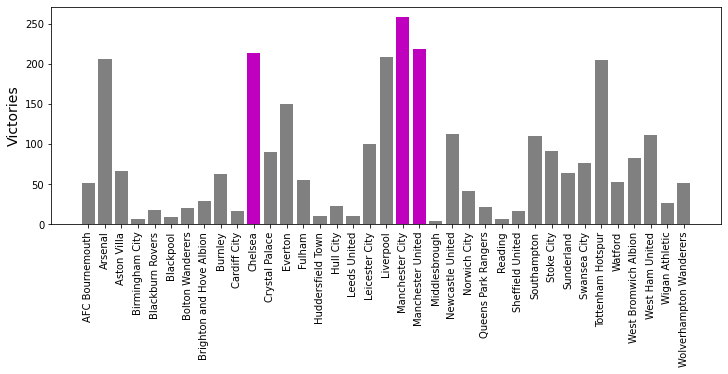

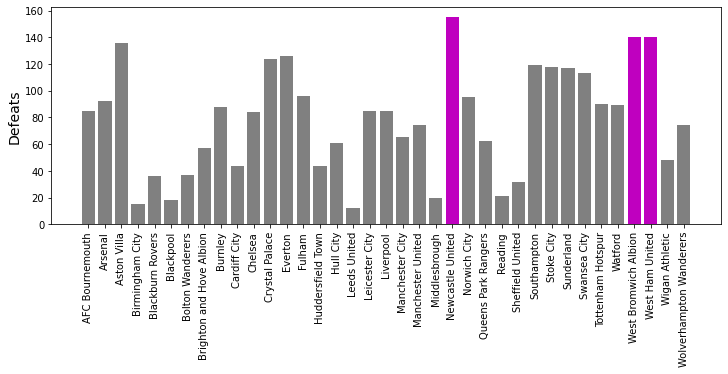

In [9]:
# Count victories and defeats for each team
teams = np.unique(df["home_team"].values)
teams_victories, teams_defeats = {}, {}
for team in teams:
    home_victories = (df[df["home_team"]==team]["result"]==1).sum()
    home_deafeats = (df[df["home_team"]==team]["result"]==-1).sum()
    away_victories = (df[df["away_team"]==team]["result"]==-1).sum()
    away_defeats = (df[df["away_team"]==team]["result"]==1).sum()
    teams_victories[team] = home_victories + away_victories
    teams_defeats[team] = home_deafeats + away_defeats

plt.figure(figsize=(12,4))
x = range(len(teams_victories))
colors = np.array(['gray']*len(x))
colors[np.argsort(list(teams_victories.values()))[-3:]] = 'm'
plt.bar(x, list(teams_victories.values()), align='center', color=colors)
plt.xticks(range(len(teams_victories)), list(teams_victories.keys()), rotation=90);
plt.ylabel("Victories", fontsize=14)
plt.show()

plt.figure(figsize=(12,4))
x = range(len(teams_defeats))
colors = np.array(['gray']*len(x))
colors[np.argsort(list(teams_defeats.values()))[-3:]] = 'm'
plt.bar(x, list(teams_defeats.values()), align='center', color=colors)
plt.xticks(range(len(teams_defeats)), list(teams_defeats.keys()), rotation=90);
plt.ylabel("Defeats", fontsize=14)
plt.show()

### Transform data

In [10]:
categorical_features = np.array(df.columns[np.where(df.dtypes==object)])
numerical_features = np.array(df.columns[np.where(df.dtypes==float)])
print(f"Categorical features: {categorical_features}")
print(f"Numerical features: {numerical_features[:4]} ...")

Categorical features: ['season' 'home_team' 'away_team']
Numerical features: ['home_clearances' 'home_corners' 'home_fouls_conceded' 'home_offsides'] ...


In [11]:
# One-hot encoding of teams
ordinal_encoder = OrdinalEncoder()
ordinal_encoder.fit(df["home_team"].values.reshape(-1, 1))
home_team_ordinal_encoded = ordinal_encoder.transform(df["home_team"].values.reshape(-1, 1)).astype(int)
away_team_ordinal_encoded = ordinal_encoder.transform(df["away_team"].values.reshape(-1, 1)).astype(int)

team_names = df["home_team"].values
team_numbers = home_team_ordinal_encoded.flatten()
team_dict = {}
for team_number,team_name in zip(team_numbers, team_names):
    team_dict[team_number] = team_name
    
onehot_home_team_col_names = []
onehot_away_team_col_names = []
for i in range(len(team_dict)):
    onehot_home_team_col_names.append("home_team__" + team_dict[i])
    onehot_away_team_col_names.append("away_team__" + team_dict[i])

onehot_encoder = OneHotEncoder()
home_team_onehot_encoded = onehot_encoder.fit_transform(home_team_ordinal_encoded.reshape(-1, 1)).todense()
away_team_onehot_encoded = onehot_encoder.fit_transform(away_team_ordinal_encoded.reshape(-1, 1)).todense()

df_home_team_onehot = pd.DataFrame(home_team_onehot_encoded, columns=onehot_home_team_col_names)
df_away_team_onehot = pd.DataFrame(away_team_onehot_encoded, columns=onehot_away_team_col_names)

df = pd.concat([df, df_home_team_onehot, df_away_team_onehot], axis=1).drop(columns=["home_team", "away_team"])

# One-hot encoding of seasons
ordinal_encoder.fit(df["season"].values.reshape(-1, 1))
season_ordinal_encoded = ordinal_encoder.transform(df["season"].values.reshape(-1, 1)).astype(int)
season_onehot_encoded = onehot_encoder.fit_transform(season_ordinal_encoded.reshape(-1, 1)).todense()
onehot_season_col_names = pd.get_dummies(df["season"]).columns
df_season_onehot = pd.DataFrame(season_onehot_encoded, columns=onehot_season_col_names)
df = pd.concat([df, df_season_onehot], axis=1).drop(columns=["season"])

print(f"{df.shape} <-- (rows, columns)")
display(df.head())

(3841, 187) <-- (rows, columns)


,date,home_clearances,home_corners,home_fouls_conceded,home_offsides,home_passes,home_possession,home_red_cards,home_shots,home_shots_on_target,...,11/12,12/13,13/14,14/15,15/16,16/17,17/18,18/19,19/20,20/21
0,2010-11-01,15.0,8.0,16.0,2.0,550.0,65.4,0.0,26.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2011-04-11,16.0,6.0,6.0,5.0,527.0,53.1,0.0,21.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2010-12-13,26.0,5.0,9.0,3.0,430.0,46.1,0.0,17.0,6.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2010-09-13,26.0,8.0,12.0,2.0,277.0,43.3,0.0,21.0,9.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2011-02-14,50.0,4.0,11.0,1.0,333.0,37.4,0.0,13.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [12]:
# Scaling of numerical values
scaler = MinMaxScaler()
df[numerical_features] = scaler.fit_transform(df[numerical_features])
display(df.head())

,date,home_clearances,home_corners,home_fouls_conceded,home_offsides,home_passes,home_possession,home_red_cards,home_shots,home_shots_on_target,...,11/12,12/13,13/14,14/15,15/16,16/17,17/18,18/19,19/20,20/21
0,2010-11-01,0.205479,0.421053,0.666667,0.181818,0.445769,0.730354,0.0,0.590909,0.294118,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2011-04-11,0.219178,0.315789,0.250000,0.454545,0.418355,0.540832,0.0,0.477273,0.294118,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2010-12-13,0.356164,0.263158,0.375000,0.272727,0.302741,0.432974,0.0,0.386364,0.352941,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2010-09-13,0.356164,0.421053,0.500000,0.181818,0.120381,0.389831,0.0,0.477273,0.529412,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2011-02-14,0.684932,0.210526,0.458333,0.090909,0.187128,0.298921,0.0,0.295455,0.294118,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Split data
* **Trainset:** matches to 2019 (included) 
* **Evaluation set:** matches from 2020
* **Test set:** matches from 2021

**Note:** it is important take an evaluation set closest to the test set in time instead of using cross-validation because the teams and their performance evolves significantly over time.

In [13]:
TRAIN_DATE_END = "2019-12-31"
EVAL_DATE_END = "2020-12-31"

train_mask = df["date"]<=TRAIN_DATE_END
eval_mask = (df["date"]>TRAIN_DATE_END) & (df["date"]<=EVAL_DATE_END)
test_mask = df["date"]>EVAL_DATE_END

X_train = df[train_mask].drop(columns="result")
X_eval = df[eval_mask].drop(columns="result")
X_train_extended = pd.concat([X_train, X_eval])
X_test = df[test_mask].drop(columns="result")
y_train = df[train_mask]["result"]
y_eval = df[eval_mask]["result"]
y_train_extended = pd.concat([y_train, y_eval])
y_test = df[test_mask]["result"]

print(f"Train ({train_mask.sum()} matches)")
display(df[train_mask].head())
print(f"Eval ({eval_mask.sum()} matches)")
display(df[eval_mask].head())
print(f"Test ({test_mask.sum()} matches)")
display(df[test_mask].head())

Train (3411 matches)


,date,home_clearances,home_corners,home_fouls_conceded,home_offsides,home_passes,home_possession,home_red_cards,home_shots,home_shots_on_target,...,11/12,12/13,13/14,14/15,15/16,16/17,17/18,18/19,19/20,20/21
0,2010-11-01,0.205479,0.421053,0.666667,0.181818,0.445769,0.730354,0.0,0.590909,0.294118,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2011-04-11,0.219178,0.315789,0.250000,0.454545,0.418355,0.540832,0.0,0.477273,0.294118,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2010-12-13,0.356164,0.263158,0.375000,0.272727,0.302741,0.432974,0.0,0.386364,0.352941,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2010-09-13,0.356164,0.421053,0.500000,0.181818,0.120381,0.389831,0.0,0.477273,0.529412,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2011-02-14,0.684932,0.210526,0.458333,0.090909,0.187128,0.298921,0.0,0.295455,0.294118,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Eval (313 matches)


,date,home_clearances,home_corners,home_fouls_conceded,home_offsides,home_passes,home_possession,home_red_cards,home_shots,home_shots_on_target,...,11/12,12/13,13/14,14/15,15/16,16/17,17/18,18/19,19/20,20/21
3232,2020-01-10,0.150685,0.368421,0.458333,0.272727,0.311085,0.445300,0.0,0.295455,0.176471,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3233,2020-02-14,0.205479,0.368421,0.541667,0.181818,0.181168,0.351310,0.0,0.340909,0.176471,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3234,2020-07-17,0.383562,0.473684,0.458333,0.090909,0.144219,0.348228,0.0,0.227273,0.235294,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3235,2020-06-19,0.205479,0.473684,0.375000,0.272727,0.274136,0.570108,0.0,0.204545,0.058824,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3236,2020-06-19,0.410959,0.368421,0.708333,0.090909,0.225268,0.320493,0.0,0.227273,0.176471,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


Test (117 matches)


,date,home_clearances,home_corners,home_fouls_conceded,home_offsides,home_passes,home_possession,home_red_cards,home_shots,home_shots_on_target,...,11/12,12/13,13/14,14/15,15/16,16/17,17/18,18/19,19/20,20/21
3592,2021-01-01,0.219178,0.263158,0.375000,0.181818,0.492253,0.647149,0.0,0.227273,0.117647,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3593,2021-01-01,0.342466,0.263158,0.916667,0.090909,0.275328,0.468413,0.0,0.431818,0.529412,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3595,2021-02-19,0.164384,0.368421,0.541667,0.090909,0.157330,0.354391,0.0,0.340909,0.294118,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3601,2021-03-01,0.315068,0.210526,0.541667,0.363636,0.278903,0.440678,0.0,0.159091,0.058824,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3602,2021-02-15,0.232877,0.526316,0.375000,0.000000,0.462455,0.733436,0.0,0.409091,0.352941,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [14]:
# Derive sample weights from date
timedeltas = (pd.to_datetime(EVAL_DATE_END) - X_train["date"]).astype('timedelta64[D]').astype(int)
scaled_timedeltas = timedeltas.values / timedeltas.max()
X_train["sample_weight"] = 1 - scaled_timedeltas

timedeltas = (pd.to_datetime(EVAL_DATE_END) - X_train_extended["date"]).astype('timedelta64[D]').astype(int)
scaled_timedeltas = timedeltas.values / timedeltas.max()
X_train_extended["sample_weight"] = 1 - scaled_timedeltas

### Train and predict

In [15]:
# Select features and models
FEATURES = np.delete(X_train.columns, np.where((X_train.columns=="date") + (X_train.columns=="sample_weight")))
MODELS = [RandomForestClassifier(), LogisticRegression(multi_class="multinomial", max_iter=500), SVC(),
          DecisionTreeClassifier(), GaussianNB(), GradientBoostingClassifier(), MLPClassifier(max_iter=500),
          Perceptron(), xgb.XGBClassifier(), KNeighborsClassifier(), GaussianProcessClassifier()]

accs_eval = []
for model in MODELS:
    start = time.time()
    print(model)
    
    if ("random_state" in model.get_params().keys()):
        model.set_params(random_state=SEED)
    
    # Exceptions of models not supporting `sample_weight`
    if ((type(model)==type(MLPClassifier())) +
        (type(model)==type(KNeighborsClassifier()))+ 
        (type(model)==type(GaussianProcessClassifier()))):
        model.fit(X_train[FEATURES], y_train)
    else:
        model.fit(X_train[FEATURES], y_train, sample_weight=X_train["sample_weight"].values)
    
    y_train_pred = model.predict(X_train[FEATURES])
    acc_train = accuracy_score(y_train, y_train_pred)
    
    y_eval_pred = model.predict(X_eval[FEATURES])
    acc_eval = accuracy_score(y_eval, y_eval_pred)
    
    y_test_pred = model.predict(X_test[FEATURES])
    acc_test = accuracy_score(y_test, y_test_pred)
    
    accs_eval.append(acc_eval)
    print(f"Accuracy in trainset = {acc_train:.3f}")
    print(f"Accuracy in evalset = {acc_eval:.3f}")
    print(f"Accuracy in testset = {acc_test:.3f}")
    
    print(f"Done ({(time.time() - start):.2f} seconds)\n")
    
best_model = MODELS[np.argmax(accs_eval)]
print(f"Best out-of-the-box model: {best_model}")


RandomForestClassifier()
Accuracy in trainset = 1.000
Accuracy in evalset = 0.562
Accuracy in testset = 0.547
Done (1.74 seconds)

LogisticRegression(max_iter=500, multi_class='multinomial')
Accuracy in trainset = 0.682
Accuracy in evalset = 0.642
Accuracy in testset = 0.607
Done (0.81 seconds)

SVC()
Accuracy in trainset = 0.658
Accuracy in evalset = 0.604
Accuracy in testset = 0.573
Done (4.22 seconds)

DecisionTreeClassifier()
Accuracy in trainset = 0.999
Accuracy in evalset = 0.540
Accuracy in testset = 0.453
Done (0.31 seconds)

GaussianNB()
Accuracy in trainset = 0.520
Accuracy in evalset = 0.470
Accuracy in testset = 0.402
Done (0.06 seconds)

GradientBoostingClassifier()
Accuracy in trainset = 0.785
Accuracy in evalset = 0.655
Accuracy in testset = 0.615
Done (16.35 seconds)

MLPClassifier(max_iter=500)


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Accuracy in trainset = 1.000
Accuracy in evalset = 0.610
Accuracy in testset = 0.530
Done (21.14 seconds)

Perceptron()
Accuracy in trainset = 0.660
Accuracy in evalset = 0.636
Accuracy in testset = 0.581
Done (0.08 seconds)

XGBClassifier()
Accuracy in trainset = 0.741
Accuracy in evalset = 0.639
Accuracy in testset = 0.607
Done (8.15 seconds)

KNeighborsClassifier()
Accuracy in trainset = 0.661
Accuracy in evalset = 0.447
Accuracy in testset = 0.402
Done (0.54 seconds)

GaussianProcessClassifier()
Accuracy in trainset = 0.856
Accuracy in evalset = 0.537
Accuracy in testset = 0.513
Done (57.51 seconds)

Best out-of-the-box model: GradientBoostingClassifier(random_state=20210605)


Epoch 1/20
35/35 [==============================] - 0s 11ms/step - loss: 1.2220 - accuracy: 0.3867 - val_loss: 1.0687 - val_accuracy: 0.4345
Epoch 2/20
35/35 [==============================] - 0s 6ms/step - loss: 1.0672 - accuracy: 0.4656 - val_loss: 1.0646 - val_accuracy: 0.4345
Epoch 3/20
35/35 [==============================] - 0s 4ms/step - loss: 1.0470 - accuracy: 0.4705 - val_loss: 1.0633 - val_accuracy: 0.4345
Epoch 4/20
35/35 [==============================] - 0s 3ms/step - loss: 1.0307 - accuracy: 0.4902 - val_loss: 1.0531 - val_accuracy: 0.4345
Epoch 5/20
35/35 [==============================] - 0s 3ms/step - loss: 1.0228 - accuracy: 0.5007 - val_loss: 1.0476 - val_accuracy: 0.4345
Epoch 6/20
35/35 [==============================] - 0s 4ms/step - loss: 1.0045 - accuracy: 0.5101 - val_loss: 1.0270 - val_accuracy: 0.4728
Epoch 7/20
35/35 [==============================] - 0s 4ms/step - loss: 0.9917 - accuracy: 0.5177 - val_loss: 1.0194 - val_accuracy: 0.4569
Epoch 8/20
35/35 [=

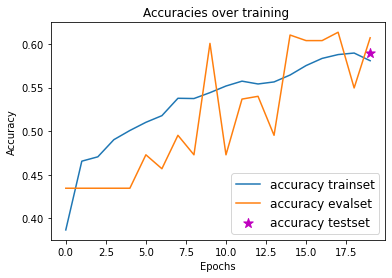

In [16]:
# Define model
model = Sequential([
    Dense(100, input_shape=(X_train[FEATURES].shape[1],), activation="relu"),
    Dropout(0.5),
    BatchNormalization(),
    Dense(10, activation="relu"),
    Dropout(0.5),
    Dense(3, activation="softmax")
])

# Define training parameters
model.compile(optimizer=keras.optimizers.SGD(lr=0.1),
              loss="categorical_crossentropy",
              metrics=["accuracy"])

# Train model
# model.fit(X_train[FEATURES].values, y_train_tf, epochs=30, shuffle=False)
history = model.fit(X_train[FEATURES].values, encode_match_results(y_train),
                    validation_data=(X_eval[FEATURES].values, encode_match_results(y_eval)),
                    batch_size=100, epochs=20, shuffle=False, verbose=1)
acc_train_history = history.history["accuracy"]
acc_eval_history = history.history["val_accuracy"]
accs_eval.append(acc_eval_history[-1])

# Compute accuracy on testset
acc_test = model.evaluate(X_test[FEATURES].values, encode_match_results(y_test), verbose=0)[1]
print(f"Accuracy in testset = {acc_test:.3f}")

# Visualize accuracy over training
plt.plot(acc_train_history, label="accuracy trainset")
plt.plot(acc_eval_history, label="accuracy evalset")
plt.scatter(len(acc_eval_history)-1, acc_test, marker='*', c='m', s=100, label="accuracy testset")
plt.legend(loc='lower right', fontsize=12)
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracies over training ")
plt.show()

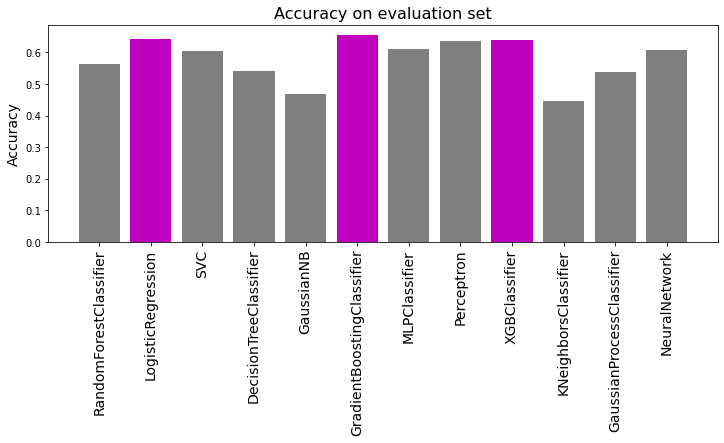

In [17]:
plt.figure(figsize=(12,4))
x = np.arange(len(accs_eval))
names = [str(model).split('(')[0] for model in MODELS] + ["NeuralNetwork"]
colors = np.array(['gray']*len(x))
colors[np.argsort(accs_eval)[-3:]] = 'm'
plt.bar(x, accs_eval, color=colors)
plt.xticks(x, names, rotation=90, fontsize=14)
plt.title("Accuracy on evaluation set", fontsize=16)
plt.ylabel("Accuracy", fontsize=14)
plt.show()

In [18]:
LOGISTIC_REGRESSION = LogisticRegression(multi_class="multinomial", max_iter=500, random_state=SEED)

PARAMETERS = {"C":np.logspace(-4, 4, 20),
              "penalty":["l1", "l2", "elasticnet"],
              "solver":["saga"],}

print(f"Running grid search")
start_search = time.time()
acc_eval_search = []
models = []
parameter_grid = list(ParameterGrid(PARAMETERS))
for i, parameters_i in enumerate(parameter_grid):
    start = time.time()
    model = copy.copy(LOGISTIC_REGRESSION)
    if (parameters_i["penalty"] == "elasticnet"):
        parameters_i["l1_ratio"] = 0.5
    model.set_params(**parameters_i)
    model.fit(X_train[FEATURES], y_train, sample_weight=X_train["sample_weight"].values)
    models.append(model)
    y_eval_pred = model.predict(X_eval[FEATURES])
    acc_eval = accuracy_score(y_eval, y_eval_pred)
    acc_eval_search.append(acc_eval)
    
print(f"Done ({(time.time() - start_search):.2f} seconds)\n")

best_hyperparameters = parameter_grid[np.argmax(acc_eval_search)]
print(f"Best hyperparameters model:\n{best_hyperparameters}")
print(f"Accuracy in evalset = {np.max(acc_eval_search):.4f}")

# Final prediction: train using trainset and evalset together and predict on testset
start = time.time()
print("Training best model with extended trainset...")
BEST_LOGISTIC_REGRESSION = models[np.argmax(acc_eval_search)]
BEST_LOGISTIC_REGRESSION.fit(X_train_extended[FEATURES], y_train_extended, 
                             sample_weight=X_train_extended["sample_weight"].values)

y_test_pred = BEST_LOGISTIC_REGRESSION.predict(X_test[FEATURES])
acc_test = accuracy_score(y_test, y_test_pred)
print(f"Accuracy in testset = {acc_test:.4f}")

# Add prediction
df_test = df_before_drop[df_before_drop["date"]>EVAL_DATE_END][["date", "home_team", "away_team", "result"]]
df_test["result_prediction"] = y_test_pred

print(f"Done ({(time.time() - start):.2f} seconds)\n")

Running grid search


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did 

Done (377.78 seconds)

Best hyperparameters model:
{'C': 11.288378916846883, 'penalty': 'elasticnet', 'solver': 'saga', 'l1_ratio': 0.5}
Accuracy in evalset = 0.6677
Training best model with extended trainset...
Accuracy in testset = 0.6325
Done (15.41 seconds)



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


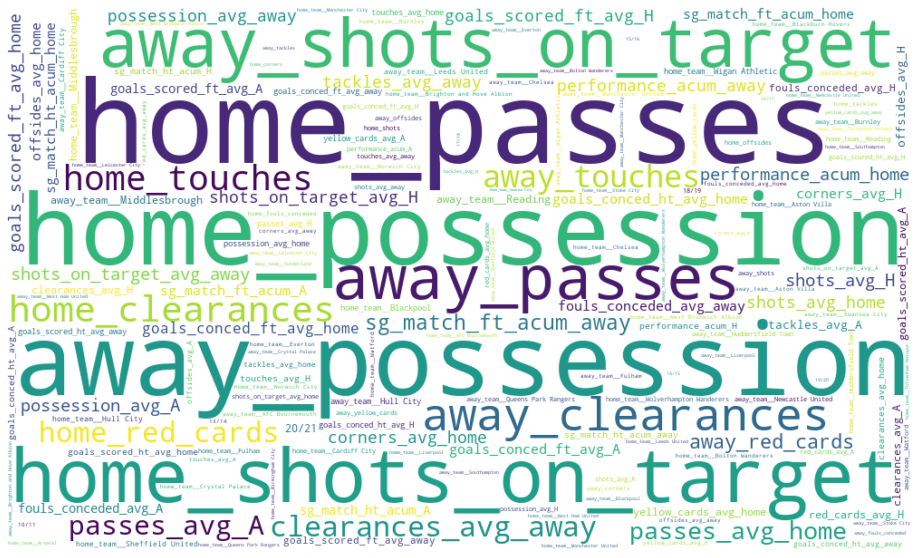

In [19]:
weights = BEST_LOGISTIC_REGRESSION.coef_
summarized_weights = np.mean(np.abs(weights),axis=0)
feature_weights_dict = {}
for feature,weight in zip(X_train[FEATURES].columns, summarized_weights):
    feature_weights_dict[feature] = weight
    
plt.figure(figsize=(20,10))
wordcloud = WordCloud(width=1000, height=600, background_color="white").fit_words(feature_weights_dict)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [20]:
GRADIENT_BOOSTING = GradientBoostingClassifier(random_state=SEED)

PARAMETERS = {"n_estimators": np.arange(60,140,20),
              "subsample": [0.5, 0.75, 1]}

print(f"Running grid search")
start_search = time.time()
acc_eval_search = []
models = []
parameter_grid = list(ParameterGrid(PARAMETERS))
for i, parameters_i in enumerate(parameter_grid):
    start = time.time()
    model = copy.copy(GRADIENT_BOOSTING)
    model.set_params(**parameters_i)
    model.fit(X_train[FEATURES], y_train, sample_weight=X_train["sample_weight"].values)
    models.append(model)
    y_eval_pred = model.predict(X_eval[FEATURES])
    acc_eval = accuracy_score(y_eval, y_eval_pred)
    acc_eval_search.append(acc_eval)
    
print(f"Done ({(time.time() - start_search):.2f} seconds)\n")

best_hyperparameters = parameter_grid[np.argmax(acc_eval_search)]
print(f"Best hyperparameters model:\n{best_hyperparameters}")
print(f"Accuracy in evalset = {np.max(acc_eval_search):.4f}")

# Final prediction: train using trainset and evalset together and predict on testset
BEST_GRADIENT_BOOSTING = models[np.argmax(acc_eval_search)]
BEST_GRADIENT_BOOSTING.fit(X_train_extended[FEATURES], y_train_extended)
y_test_pred = BEST_GRADIENT_BOOSTING.predict(X_test[FEATURES])
acc_test = accuracy_score(y_test, y_test_pred)
print(f"Accuracy in test = {acc_test:.4f}")

Running grid search
Done (166.53 seconds)

Best hyperparameters model:
{'n_estimators': 100, 'subsample': 1}
Accuracy in evalset = 0.6550
Accuracy in test = 0.5812


## Goal count prediction (statistical)

In [21]:
# Get all team pairs
pairs = [[a, b] for idx, a in enumerate(np.unique(team_names)) for b in np.unique(team_names)[idx + 1:]]
mirrored_pairs = []
for pair in pairs:
    mirrored_pairs.append(pair[::-1])
pairs_complete = pairs + mirrored_pairs 

# Split data
mask_train = df_before_drop["date"] <= EVAL_DATE_END
mask_test = df_before_drop["date"] > EVAL_DATE_END
df_train = df_before_drop[mask_train]
df_test = df_before_drop[mask_test]

y_pred = []
correct = 0
incorrect = 0
for match in df_test.iterrows():

    # Select old same matches
    pair_mask = ((df_train["home_team"]==match[1]["home_team"]) & (df_train["away_team"]==match[1]["away_team"]))
    if (pair_mask.any()):
        # Get their score
        scores = df_train[pair_mask][["goal_home_ft", "goal_away_ft"]]
        # Compute their median
        match_pred = np.median(scores.values, axis=0).astype(int)
        if(match_pred[0]<0):
            break
        y_pred.append(match_pred)

        if ((match_pred[0]==match[1]["goal_home_ft"]) * (match_pred[1]==match[1]["goal_away_ft"])):
            correct += 1
        else:
            incorrect += 1
    else:
        y_pred.append("no_history")
        
y_pred_humanized = []
for y in y_pred:
    if len(y)==2:
        home_goals = y[0]
        away_goals = y[1]
        y_pred_humanized.append(f"{home_goals}-{away_goals}")
    else:
        y_pred_humanized.append("no_history")
print(y_pred_humanized)

acc = correct / df_test.shape[0]
print(f"\nACCURACY = {acc*100:.2f}%")

['3-1', '2-0', '1-1', '0-1', 'no_history', '1-1', '0-3', '2-1', '0-2', '0-0', '0-2', '0-2', '1-0', '3-0', '2-1', 'no_history', '1-2', '1-0', '1-1', '2-3', '3-1', '3-0', '1-1', '2-0', '2-1', '1-2', '4-0', '0-3', '2-1', '1-0', '1-1', '1-1', 'no_history', '1-3', '2-0', '1-1', '2-2', '3-0', '2-1', '1-1', '1-0', '0-1', '2-0', '2-1', '1-1', '2-1', '1-1', '1-2', 'no_history', '2-1', '1-1', 'no_history', '0-2', '1-0', '2-0', 'no_history', '1-1', '1-1', '1-1', '1-1', '1-0', '2-1', '1-2', '1-1', '1-1', '2-1', '1-1', '3-0', '3-1', 'no_history', '1-1', '0-0', '1-2', '2-1', '2-2', '1-2', '3-0', 'no_history', '1-1', '2-1', '1-1', '2-1', 'no_history', '2-0', '1-2', 'no_history', '2-2', '1-2', '1-1', '3-1', '1-0', '0-1', 'no_history', 'no_history', '2-1', '1-1', '2-0', '0-1', '2-1', '2-1', '1-2', '2-1', '1-1', '3-1', '2-0', '1-1', '1-2', '1-1', '1-2', '1-1', '0-2', '0-1', '0-1', '0-1', '1-1', '1-1', '2-0']

ACCURACY = 5.13%


### Save results

In [22]:
df_test = df_before_drop[df_before_drop["date"]>EVAL_DATE_END][["date", "home_team", "away_team", "result_full", "result"]]
df_test["result_prediction"] = y_test_pred
df_test["score_prediction"] = y_pred_humanized
display(df_test.head())
df_test.to_csv(os.path.dirname(PATH) + "\\epl_predictions.csv")

,date,home_team,away_team,result_full,result,result_prediction,score_prediction
3593,2021-01-01,Manchester United,Aston Villa,2-1,1,-1,3-1
3592,2021-01-01,Everton,West Ham United,0-1,-1,1,2-0
3645,2021-01-02,Brighton and Hove Albion,Wolverhampton Wanderers,3-3,0,-1,1-1
3646,2021-01-02,Crystal Palace,Sheffield United,2-0,1,1,0-1
3647,2021-01-02,Tottenham Hotspur,Leeds United,3-0,1,1,no_history
